# Data analysis of LexTALE dataset

In [70]:
# import all necessary modules
import pandas as pd
import os
import re
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# read in all participant files
files = os.listdir()
ind = 1
for file in files:
    if file.endswith(".csv"):
        print(f'reading {file} now')
        reg_exp = re.compile('_\d\d')
        ppnr = file.split('_')[0]
        if ind ==1:
            data = pd.read_csv(file)
            data['Pp']= ppnr
        else:
            dummy = pd.read_csv(file)
            data = pd.concat([data,dummy], sort=True)
            data.Pp.iloc[-60:] = ppnr
        ind +=1

reading 6_data_LexTALE.csv now
reading 2_data_LexTALE.csv now
reading 5_data_LexTALE.csv now
reading 1_data_LexTALE.csv now


/Users/annemickan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
# check the data
data.head()
#data.describe()

,Pp,error,response,rt,trial_nr,word,wordstatus
0,6,0,0,0.449563,1,mensible,0
1,6,0,1,1.159710,2,scornful,1
2,6,0,1,1.089516,3,stoutly,1
3,6,1,0,0.701194,4,ablaze,1
4,6,0,0,0.632045,5,kermshaw,0


In [5]:
# for each participant, calculate their LexTALE score and print it and save them in a new dataframe
ind = 0
scores = pd.DataFrame()
for participant in data.Pp.unique():
    ind +=1
    ppdata = data[data.Pp == participant]
    score = (((ppdata[(ppdata.wordstatus == 1) & (ppdata.error == 0)].count()/40*100) + (ppdata[(ppdata.wordstatus == 0) & (ppdata.error == 0)].count()/20*100)) / 2).unique()
    scores[ind] = score
    print(f"Participant {participant} has a score of {score[0]}%")
    

Participant 6 has a score of 87.5%
Participant 2 has a score of 73.75%
Participant 5 has a score of 85.0%
Participant 1 has a score of 77.5%


/Users/annemickan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


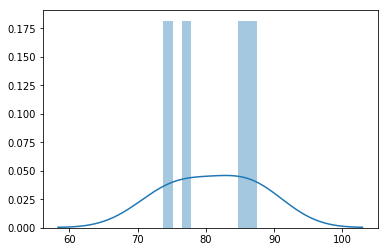

In [6]:
# make a histogram of the scores, makes more sense with more values, but oh well
sns.distplot(scores[:], bins = 10)

In [7]:
# check mean RT for nonwords and words per participant and store them in a new dataframe
cols = ['words', 'nonwords']
lst = []
for participant in data.Pp.unique():
    words = data[(data.Pp == participant) & (data.wordstatus == 1)]
    nonwords = data[(data.Pp == participant) & (data.wordstatus == 0)]
    lst.append([np.mean(words.rt),np.mean(nonwords.rt)])
rtmeans = pd.DataFrame(lst, columns=cols)
print(rtmeans)

      words  nonwords
0  0.680327  0.674392
1  0.503514  0.598150
2  1.349281  1.600507
3  0.497123  0.578150


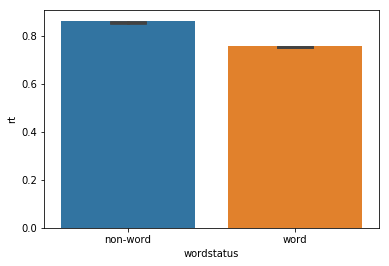

In [34]:
# plot mean RTs for words and non-words, with 95% confidence interval
data.wordstatus = data.wordstatus.replace([0,1], ["non-word","word"])
plot = sns.barplot(x = "wordstatus", y = "rt", ci = .95, capsize=.2, data = data)
data.wordstatus = data.wordstatus.replace(["non-word","word"],[0,1]) # revert the wordstatus variable to numbers 

In [49]:
# run a generalized linear model to test whether people make more errors for words and nonwords
# no random effects possible here
model = sm.GLM(data.error, data.wordstatus, family=sm.families.family.Binomial()) 
results = model.fit()
print(results.summary())
# people do make more errors on non-words than on words

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  error   No. Observations:                  240
Model:                            GLM   Df Residuals:                      239
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -117.65
Date:                Thu, 06 Dec 2018   Deviance:                       235.31
Time:                        15:03:26   Pearson chi2:                     240.
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wordstatus    -1.8900      0.234     -8.073      0.000      -2.349      -1.431


In [64]:
# run a generalized mixed effects model with a random intercept for subjects, and a random slope for trials over subjects
random = ['0 + Pp', '0 + Pp*trial_nr']
ind = [data.Pp,data.trial_nr]
model = sm.BinomialBayesMixedGLM(data.error,data.wordstatus,random,ind) 
results = model.fit()
print(results.summary())
# this does not and I did not have time enough to figure out why... 

AttributeError: 'list' object has no attribute 'shape'

In [66]:
# run a generalized linear model to test whether people are slower to respond for words than nonwords
# no random effects possible in this model, but a log-link function to log-transform the RTs
modelrt = sm.GLM(data.rt, data.wordstatus, family=sm.families.family.Gaussian(link=sm.families.links.log)) 
resultsrt = modelrt.fit()
print(resultsrt.summary())
# nonwords are responded to slower than words

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     rt   No. Observations:                  240
Model:                            GLM   Df Residuals:                      239
Model Family:                Gaussian   Df Model:                            0
Link Function:                    log   Scale:                         0.36287
Method:                          IRLS   Log-Likelihood:                -218.40
Date:                Thu, 06 Dec 2018   Deviance:                       86.727
Time:                        15:11:38   Pearson chi2:                     86.7
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wordstatus    -0.2777      0.063     -4.417      0.000      -0.401      -0.154


In [79]:
# log transform the RTs
data['rtlog'] = np.log(data.rt)
# run a linear mixed effects model with a random intercept for subjects and a random slope for trials number of subjects
modelrt = smf.mixedlm("rtlog~wordstatus", data, groups = data["Pp"], re_formula = "~trial_nr") 
resultsrt = modelrt.fit()
print(resultsrt.summary())
# gives a convergence wanring, so let's use the simpler model with only one random intercept over subjects 
modelrt2 = smf.mixedlm("rtlog~wordstatus", data, groups = data["Pp"]) 
resultsrt2 = modelrt2.fit()
print(resultsrt2.summary())
# Both models come to the conclusion that wordstatus does impact reaction times: nonwords are recognized as such more slowly

/Users/annemickan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/annemickan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/annemickan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   rtlog    
No. Observations:     240       Method:               REML     
No. Groups:           4         Scale:                0.1213   
Min. group size:      60        Likelihood:           -117.2765
Max. group size:      60        Converged:            No       
Mean group size:      60.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.181    0.184 -0.982 0.326 -0.541  0.180
wordstatus           -0.156    0.048 -3.231 0.001 -0.250 -0.061
Group Var             0.121    0.174                           
Group x trial_nr Cov  0.000    0.203                           
trial_nr Var          0.121                                    

         Mixed Linear Model Regression Results
Model

/Users/annemickan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/annemickan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/annemickan/anaconda3/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
/Users/annemickan/anaconda3/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/annemickan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid val